# ARIMA and SARIMA on Cloud Cost Data

In this notebook, we will be trying out ARIMA and SARIMA, two popular statistical method for time series forecasting on cloud cost data.

* ARIMA is acronym for AutoRegressive Integrated Moving Average. It captures a suite of different standard temporal structures in time series data and provides simple yet very powerful method for making time series forecasts.
* SARIMA is acronym for Seasonal AutoRegressive Integrated Moving Average. It is an extension of ARIMA that supports modelling of the seasonal component of the time series.


### 1. Import the required python libraries and the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn import metrics
import itertools
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../../data/cost_demo_data.csv")
df = df.rename(columns = {'usage_start' : "Time"})
df = df.rename(columns = {'unblended_cost' : "Cost"})

In [3]:
df.shape

(35, 2)

### 2. Split into Train and Test :
Splitting the dataset into Train (80%) and Test(20%)

In [4]:
train = df[0:int(len(df)*0.8)] 
test = df[int(len(df)*0.8):]

print("Train Data",train.shape)
print(train.tail())

print("Test Data",test.shape)
print(test.head())

train_time = [i+1 for i in range(len(train))]
test_time = [i+29 for i in range(len(test))]

Train Data (28, 2)
          Time  Cost
23  2020-10-24  48.0
24  2020-10-25  48.0
25  2020-10-26  48.0
26  2020-10-27  48.0
27  2020-10-28  48.0
Test Data (7, 2)
          Time       Cost
28  2020-10-29  48.000000
29  2020-10-30  48.000000
30  2020-10-31  48.000000
31  2020-11-01  34.956652
32  2020-11-02  35.074650


### 3. Auto-correlation and Partial Auto-Correlation
- Auto-correlation : 
    * Relationship of a variable with its previous time values.
    * Direct and indirect effect of various in previous time values lags
    
- Partial Auto-correlation :
    * Only direct effect of values in previous time lags
    * Used to find the order for Auto Regression Model

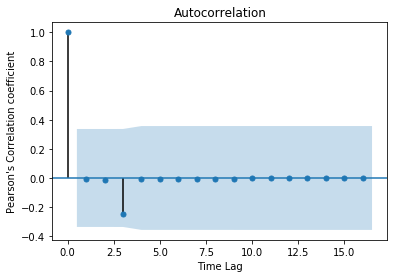

In [5]:
plot_acf(df['Cost'].diff().dropna())
plt.ylabel("Pearson's Correlation coefficient")
plt.xlabel("Time Lag")
plt.show()

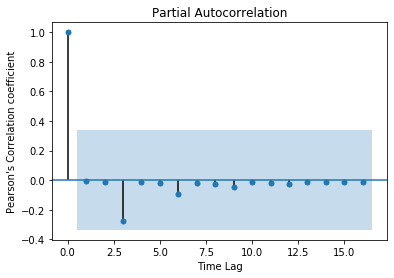

In [6]:
plot_pacf(df['Cost'].diff().dropna())
plt.ylabel("Pearson's Correlation coefficient")
plt.xlabel("Time Lag")
plt.show()

The above values of Pearson's Correlation Coefficient allows us to choose the cut off points for Arima model. We can now choose the params p and q i.e. the order of the A(auto regression) and MA(moving average) model between the range 0,2. And the param d i.e. the order of differencing for non-stationary to stationary can be kept as 1 in order to make the above time series stationary.

### 4. Automated ARIMA model :
'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [7]:
p =  range(0,3)
q = range(0, 2)
d = range(1,2)
pdq = list(itertools.product(p, d, q))
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Model: (0, 1, 1)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (2, 1, 0)
Model: (2, 1, 1)


In [8]:
arima_train = train.copy()
arima_test = test.copy()
arima_train["time"] = [i+1 for i in range(len(arima_train))]
arima_aic = pd.DataFrame(columns=['param','AIC'])

In [9]:
for param in pdq:
    arima_model = ARIMA(arima_train['Cost'].values, order=param).fit()
    print('ARIMA{} - AIC {} '.format(param,arima_model.aic))
    arima_aic = arima_aic.append({'param':param,'AIC': arima_model.aic}, ignore_index = True)

ARIMA(0, 1, 0) - AIC 162.2310033941876 
ARIMA(0, 1, 1) - AIC 164.1855352543388 
ARIMA(1, 1, 0) - AIC 164.18942745220522 
ARIMA(1, 1, 1) - AIC 164.58991487739405 
ARIMA(2, 1, 0) - AIC 166.142388630554 
ARIMA(2, 1, 1) - AIC 166.51036138262532 


In [10]:
arima_aic.sort_values(by='AIC', ascending=True)

,param,AIC
0,"(0, 1, 0)",162.231003
1,"(0, 1, 1)",164.185535
2,"(1, 1, 0)",164.189427
3,"(1, 1, 1)",164.589915
4,"(2, 1, 0)",166.142389
5,"(2, 1, 1)",166.510361


The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies:
1. the goodness of fit
2. the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”. 
* We will choose the order with lowest AIC : (0,1,0)

In [11]:
model = ARIMA(arima_train['Cost'], order=(0,1,0))
arima_results = model.fit()
print(arima_results.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Cost   No. Observations:                   27
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -79.116
Method:                           css   S.D. of innovations              4.532
Date:                Thu, 28 Jan 2021   AIC                            162.231
Time:                        20:36:52   BIC                            164.823
Sample:                             1   HQIC                           163.002
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8889      0.872     -1.019      0.308      -2.599       0.821


In [12]:
arima_train['Predictions'] = arima_results.fittedvalues
arima_train = arima_train.fillna(0)

In [13]:
arima_predictions = arima_results.forecast(steps=len(test), alpha = 0.95)
arima_predictions[0]

array([47.11111111, 46.22222222, 45.33333333, 44.44444444, 43.55555556,
       42.66666667, 41.77777778])

In [14]:
## Mean Squared Error :
arima_mse_model_train = metrics.mean_squared_error(arima_train['Cost'], arima_train['Predictions'])
print("Mean Squared Error on Test Data is : ", round(arima_mse_model_train, 2))
arima_mse_model_test = metrics.mean_squared_error(arima_test['Cost'],arima_predictions[0])
print("Mean Squared Error on Test Data is : ", round(arima_mse_model_test, 2))
## Root Mean Squared Error :
arima_rmse_train = math.sqrt(arima_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(arima_rmse_train, 2))
arima_rmse_test = math.sqrt(arima_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(arima_rmse_test, 2))

Mean Squared Error on Test Data is :  3429.33
Mean Squared Error on Test Data is :  72.7
Root Mean Squared Error on Train Data is :  58.56
Root Mean Squared Error on Test Data is :  8.53


Although the data set has some seasonality and hence ARIMA is not the right option here. The reason behind developing the ARIMA model is to understand how different the model could be if seasonality is not considered.

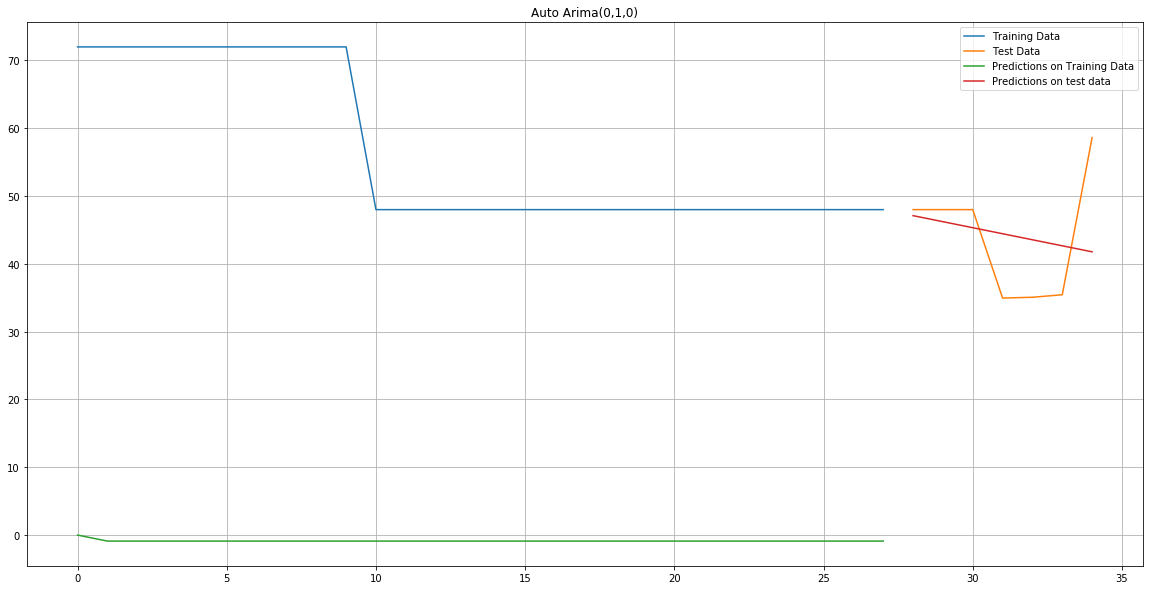

In [15]:
plt.figure(figsize=(20,10))
plt.plot(arima_train['Cost'], label = "Training Data")
plt.plot(arima_test['Cost'], label = "Test Data")
plt.plot(arima_train['Predictions'], label = "Predictions on Training Data")
plt.plot(test.index, arima_predictions[0], label = "Predictions on test data")
plt.legend(loc = "best")
plt.title("Auto Arima(0,1,0)")
plt.grid()

In [16]:
confidence_interval_arima = arima_predictions[2]
confidence_interval_arima

array([[46.82689504, 47.39532719],
       [45.82027999, 46.62416445],
       [44.84105665, 45.82561002],
       [43.87601229, 45.01287659],
       [42.92002909, 44.19108202],
       [41.97048231, 43.36285103],
       [41.02581272, 42.52974283]])

In [17]:
yerror = []
for i in range(len(confidence_interval_arima)):
    yerror.append((confidence_interval_arima[i][1] - confidence_interval_arima[i][0])/2)
print("\n Confidence Interval Error : " , yerror)


 Confidence Interval Error :  [0.2842160749928695, 0.4019422278993616, 0.4922766822154543, 0.568432149985739, 0.6355264639822309, 0.6961843604291289, 0.7519650530380133]


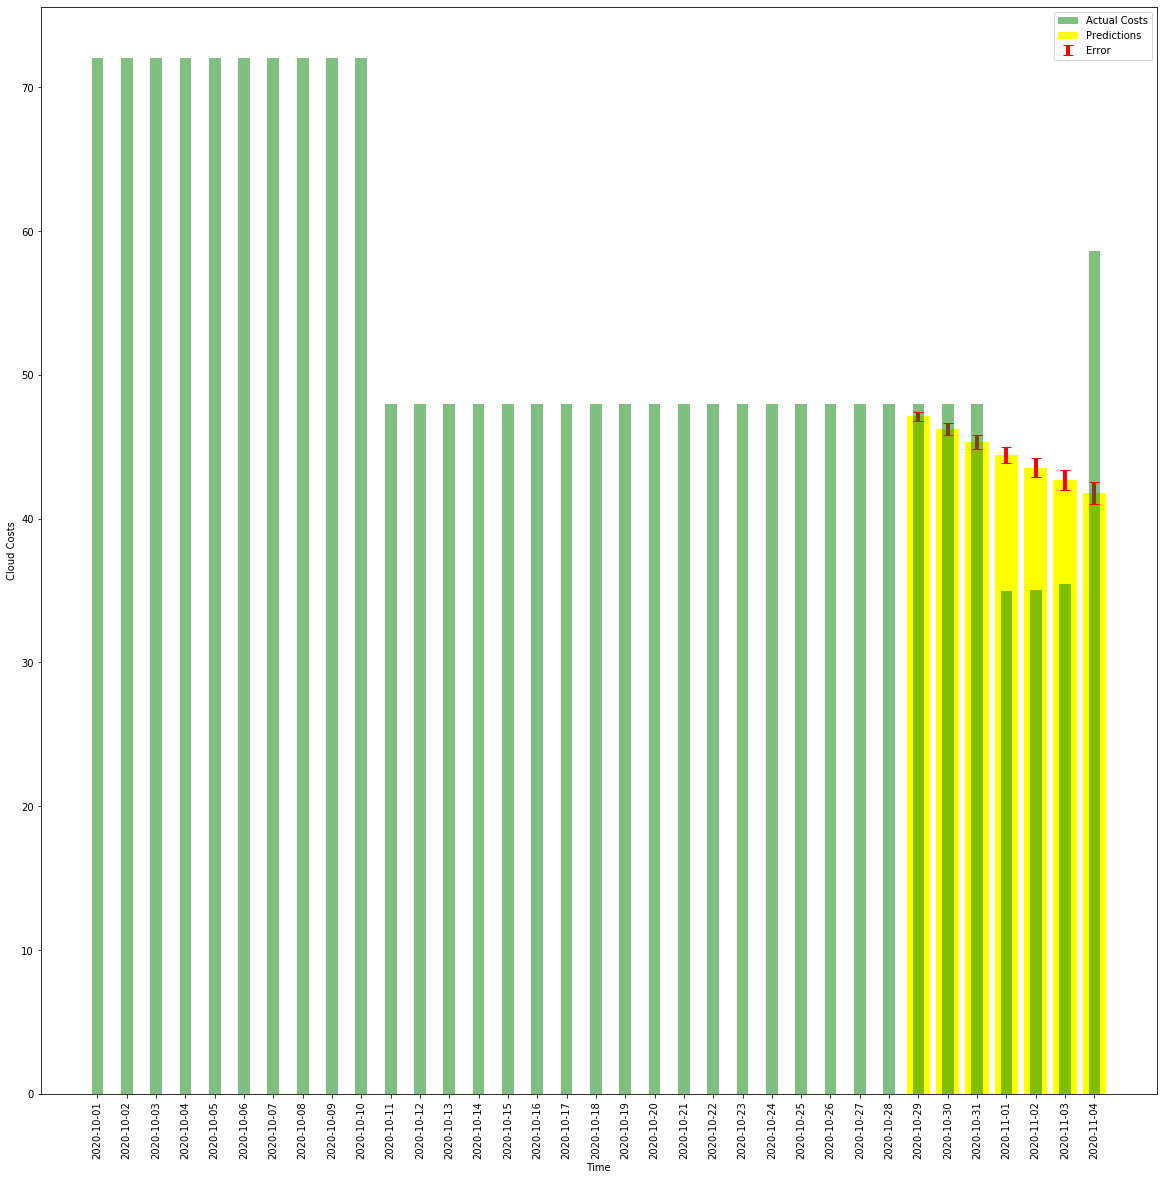

In [18]:
plt.figure(figsize=(20,20))
plt.bar(df["Time"], df["Cost"], color = "green", zorder = 2, width = 0.4, alpha =0.5, label = "Actual Costs" )
plt.bar(arima_test["Time"],arima_predictions[0], color = "yellow", zorder =1, label = "Predictions")
plt.errorbar(arima_test["Time"],arima_predictions[0], yerr= yerror, fmt = ' ', elinewidth = 4, capsize = 5, label = "Error", color = "red")
plt.xlabel("Time")
plt.ylabel("Cloud Costs")
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.show()

The above shown graph has the plot for the actual and predicted values with 5% error. Since the results aren't super accurate and do not account seasonality, we will move towards SARIMA that is an extension to ARIMA.

### 5. SARIMA model : 
After understanding the ARIMA model, we will be adding another parameter into ARIMA : S - seasonality. So, instead of transforming the "Cost" variable of our regression we can directly control the seasonality by including it as "time" feature. 

In [19]:
# m : The number of time steps for a single seasonal period. 
# For example, an S of 12 for monthly data suggests a yearly seasonal cycle.
m = 3
seasonal_pdq = [(x[0], x[1], x[2], m) for x in pdq]

In [20]:
sarima_train = train.copy()
sarima_test = test.copy()
sarima_train["time"] = [i+1 for i in range(len(sarima_train))]
sarima_aic = pd.DataFrame(columns=['param','AIC'])

In [21]:
min_aic = 999
for order in pdq:
    for param in seasonal_pdq:
        sarima_model = SARIMAX(arima_train['Cost'].values,order = order, seasonal_order=param).fit()
        print('ARIMA{} x SARIMA{} - AIC {} '.format(order,param,sarima_model.aic))
        if sarima_model.aic < min_aic:
            min_aic = sarima_model.aic
            min_aic_model = sarima_model
            min_order = order
            min_param = param
        sarima_aic = sarima_aic.append({'param':param,'AIC': sarima_model.aic}, ignore_index = True)

ARIMA(0, 1, 0) x SARIMA(0, 1, 0, 3) - AIC 163.01787385562335 
ARIMA(0, 1, 0) x SARIMA(0, 1, 1, 3) - AIC 152.14716137278577 
ARIMA(0, 1, 0) x SARIMA(1, 1, 0, 3) - AIC 158.87190373278116 
ARIMA(0, 1, 0) x SARIMA(1, 1, 1, 3) - AIC 154.1278881383684 
ARIMA(0, 1, 0) x SARIMA(2, 1, 0, 3) - AIC 158.6493423109252 
ARIMA(0, 1, 0) x SARIMA(2, 1, 1, 3) - AIC 156.0257495596291 
ARIMA(0, 1, 1) x SARIMA(0, 1, 0, 3) - AIC 165.017873856268 
ARIMA(0, 1, 1) x SARIMA(0, 1, 1, 3) - AIC 154.14715435790094 
ARIMA(0, 1, 1) x SARIMA(1, 1, 0, 3) - AIC 160.8719037386052 
ARIMA(0, 1, 1) x SARIMA(1, 1, 1, 3) - AIC 156.12795795862593 
ARIMA(0, 1, 1) x SARIMA(2, 1, 0, 3) - AIC 160.64934230233246 
ARIMA(0, 1, 1) x SARIMA(2, 1, 1, 3) - AIC 158.02576418002138 
ARIMA(1, 1, 0) x SARIMA(0, 1, 0, 3) - AIC 165.0178738561525 
ARIMA(1, 1, 0) x SARIMA(0, 1, 1, 3) - AIC 154.14716002139335 
ARIMA(1, 1, 0) x SARIMA(1, 1, 0, 3) - AIC 160.87190373407765 
ARIMA(1, 1, 0) x SARIMA(1, 1, 1, 3) - AIC 156.12789345700781 
ARIMA(1, 1, 0) 

In [22]:
sarima_aic.sort_values(by='AIC', ascending=True)
print("\n Order :", min_order,"\n","Seasonal Order :", min_param,"\n", "Minimum AIC :" ,min_aic)


 Order : (0, 1, 0) 
 Seasonal Order : (0, 1, 1, 3) 
 Minimum AIC : 152.14716137278577


The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the lower AIC is generally “better”. 
* We will choose the order with lowest AIC : ARIMA(0, 1, 0) x SARIMA(0, 1, 1, 3) - AIC 152.14716137278577 

In [23]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 3)   Log Likelihood                 -74.074
Date:                             Thu, 28 Jan 2021   AIC                            152.147
Time:                                     20:36:58   BIC                            154.503
Sample:                                          0   HQIC                           152.772
                                              - 28                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L3       -0.9994    145.368     -0.007      0.995    -285.916     283.918
sigma2        21.3529   3101.434      0.007      0.995   -6057.346    6100.052
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               250.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                            -3.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
sarima_train["Predictions"] = min_aic_model.fittedvalues
sarima_train

,Time,Cost,time,Predictions
0,2020-10-01,72.0,1,0.000000
1,2020-10-02,72.0,2,72.000000
2,2020-10-03,72.0,3,72.000000
3,2020-10-04,72.0,4,108.000000
4,2020-10-05,72.0,5,72.000000
5,2020-10-06,72.0,6,72.000000
6,2020-10-07,72.0,7,72.001536
7,2020-10-08,72.0,8,72.000000
8,2020-10-09,72.0,9,72.000000
9,2020-10-10,72.0,10,72.000768


In [25]:
sarima_forecast = min_aic_model.get_forecast(steps = len(test))
sarima_forecast

In [26]:
sarima_predictions = min_aic_model.forecast(steps = len(test))

In [27]:
## Mean Squared Error :
sarima_mse_model_train = metrics.mean_squared_error(sarima_train['Cost'], sarima_train['Predictions'])
print("Mean Squared Error on Test Data is : ", round(sarima_mse_model_train, 2))
sarima_mse_model_test = metrics.mean_squared_error(sarima_test['Cost'],sarima_predictions)
print("Mean Squared Error on Test Data is : ", round(sarima_mse_model_test, 2))
## Root Mean Squared Error :
sarima_rmse_train = math.sqrt(sarima_mse_model_train)
print("Root Mean Squared Error on Train Data is : ", round(sarima_rmse_train, 2))
sarima_rmse_test = math.sqrt(sarima_mse_model_test)
print("Root Mean Squared Error on Test Data is : ", round(sarima_rmse_test, 2))

Mean Squared Error on Test Data is :  255.42
Mean Squared Error on Test Data is :  76.76
Root Mean Squared Error on Train Data is :  15.98
Root Mean Squared Error on Test Data is :  8.76


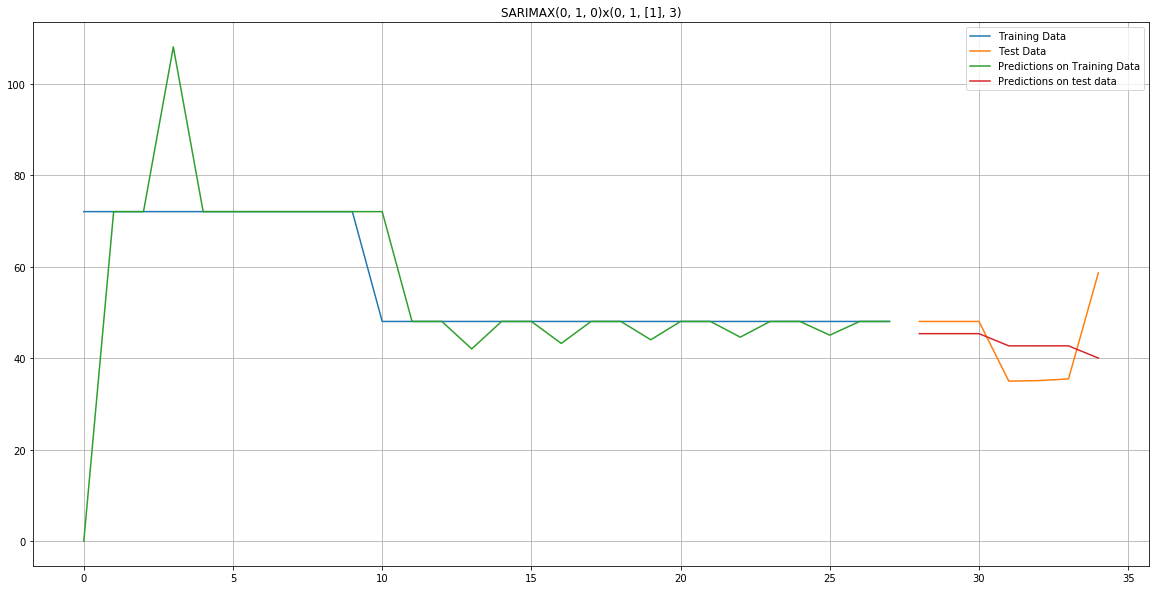

In [28]:
plt.figure(figsize=(20,10))
plt.plot(sarima_train['Cost'], label = "Training Data")
plt.plot(sarima_test['Cost'], label = "Test Data")
plt.plot(sarima_train['Predictions'], label = "Predictions on Training Data")
plt.plot(test.index, sarima_predictions, label = "Predictions on test data")
plt.legend(loc = "best")
plt.title("SARIMAX(0, 1, 0)x(0, 1, [1], 3)")
plt.grid()

In [29]:
confidence_interval = sarima_forecast.conf_int(alpha = 0.95)
print(confidence_interval)
yerror = []
for i in range(len(confidence_interval)):
    yerror.append((confidence_interval[i][1] - confidence_interval[i][0])/2)
print("\n Confidence Interval Error : " , yerror)
sarima_predictions

[[45.02800533 45.63868917]
 [44.90152857 45.76516593]
 [44.80465027 45.86238566]
 [42.04110035 43.29263008]
 [41.95731445 43.37641598]
 [41.88259801 43.45147384]
 [39.13674525 40.86402111]]

 Confidence Interval Error :  [0.30534191831122826, 0.4318186820367629, 0.5288676952967748, 0.6257648622715664, 0.7095507639196725, 0.7844379159550741, 0.8636379273446906]


array([45.33334725, 45.33334725, 45.33351796, 42.66686522, 42.66686522,
       42.66703593, 40.00038318])

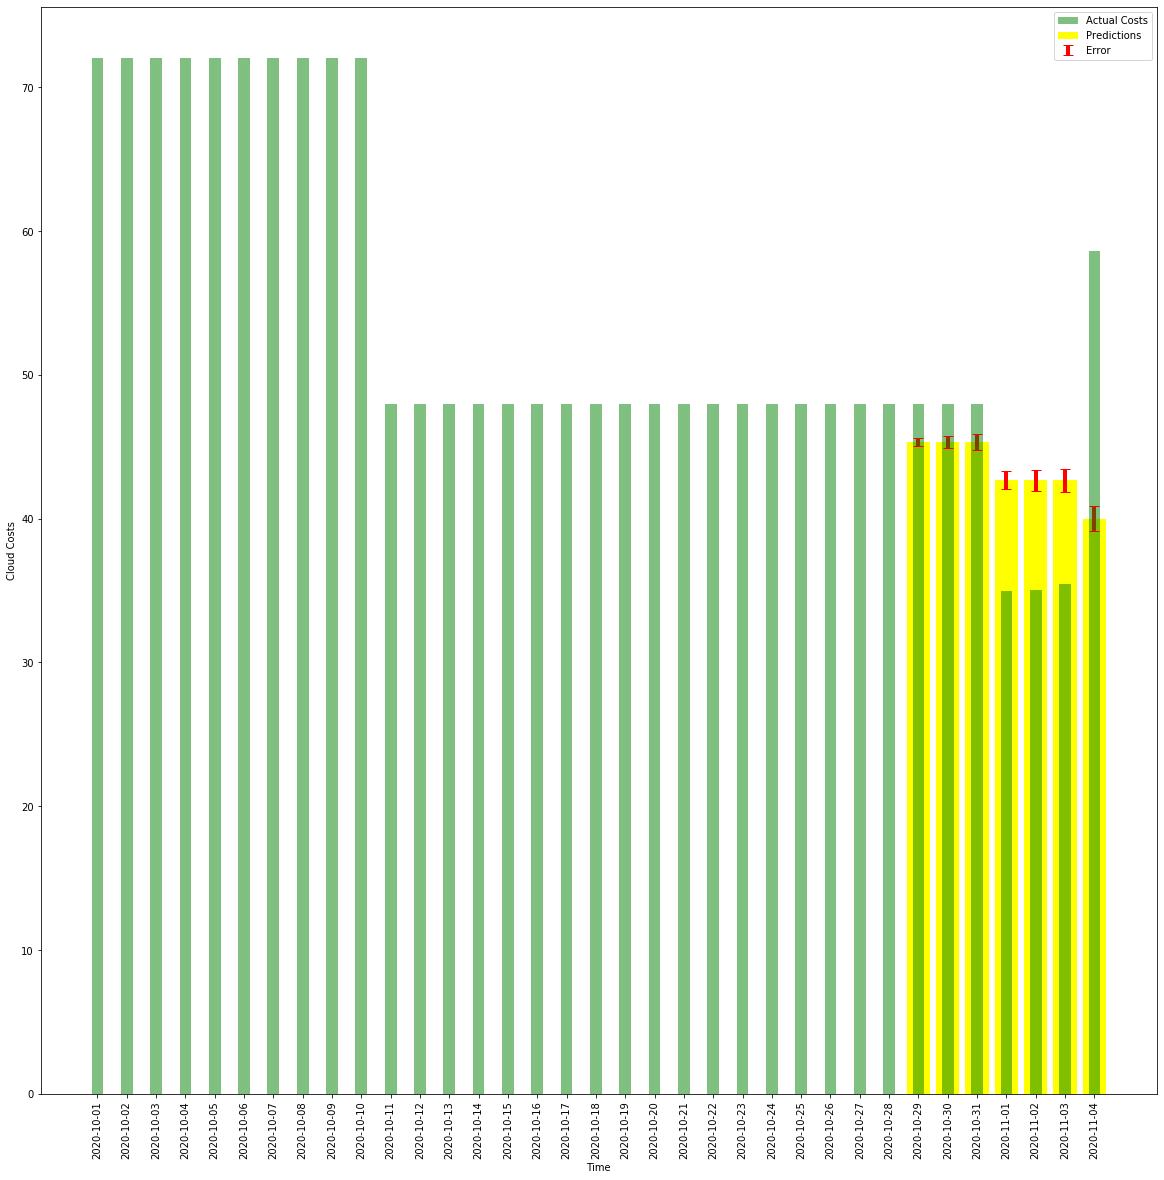

In [30]:
plt.figure(figsize=(20,20))
plt.bar(df["Time"], df["Cost"], color = "green", zorder = 2, width = 0.4, alpha =0.5, label = "Actual Costs" )
plt.bar(sarima_test["Time"],sarima_predictions, color = "yellow", zorder =1, label = "Predictions")
plt.errorbar(sarima_test["Time"],sarima_predictions, yerr= yerror, fmt = ' ', elinewidth = 4, capsize = 5, label = "Error", color = "red")
plt.xlabel("Time")
plt.ylabel("Cloud Costs")
plt.legend(loc = "best")
plt.xticks(rotation = 90)
plt.show()

### 6. Conclusion
* In this notebook, we have used two statistical methods ARIMA and SARIMA.
* The results for SARIMA are better than ARIMA and previously built Linear Regression model.
* Also added confidence intervals for 95% to the predicted value for each day. 